In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [2.1095553125, tensor(0.2564)]
valid: [1.208033203125, tensor(0.5888)]
CPU times: user 5.78 s, sys: 188 ms, total: 5.97 s
Wall time: 2 s


## CUDA

In [15]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [16]:
model = get_cnn_model(data)

In [17]:
cbfs.append(CudaCallback)

In [18]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [19]:
%time run.fit(3, learn)

train: [2.02060421875, tensor(0.2825, device='cuda:0')]
valid: [0.6757392578125, tensor(0.7904, device='cuda:0')]
train: [0.452827890625, tensor(0.8588, device='cuda:0')]
valid: [0.223053857421875, tensor(0.9338, device='cuda:0')]
train: [0.189741015625, tensor(0.9423, device='cuda:0')]
valid: [0.12420643310546875, tensor(0.9640, device='cuda:0')]
CPU times: user 2.72 s, sys: 523 ms, total: 3.25 s
Wall time: 3.07 s


## Refactor model

In [20]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [21]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [22]:
mnist_view = view_tfm(1,28,28)

In [23]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

This model can now work on any size input:

In [24]:
nfs = [8,16,32,32]

In [25]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [26]:
def get_runner(model, lr=0.6, cbs=None, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=cbfs + listify(cbs))

In [27]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.4)

In [28]:
run.fit(3, learn)

train: [2.23348890625, tensor(0.1689, device='cuda:0')]
valid: [1.5912951171875, tensor(0.4318, device='cuda:0')]
train: [0.822983046875, tensor(0.7268, device='cuda:0')]
valid: [0.273395068359375, tensor(0.9171, device='cuda:0')]
train: [0.2179859765625, tensor(0.9349, device='cuda:0')]
valid: [0.14982926025390625, tensor(0.9571, device='cuda:0')]


## Hooks

### Manual insertion

In [29]:
GLOBAL_HIST_AMPLITUDE = 10

def mkHist(x):
    #x should be a tensor..
    nBins = 200
    #hMin = torch.min(x).data #AutoScale
    #hMax = torch.max(x).data #AutoScale
    hMin = -GLOBAL_HIST_AMPLITUDE
    hMax = GLOBAL_HIST_AMPLITUDE
    ret = x.clone().detach().cpu()
    ret = ret.histc(nBins,hMin,hMax)
    return ret

In [30]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        self.act_hist  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.mean())
            self.act_stds [i].append(x.std ())
            self.act_hist[i].append(mkHist(x))
        return x
    
    def __iter__(self): return iter(self.layers)

In [31]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, lr=0.9)

In [32]:
run.fit(2, learn)

train: [2.293060625, tensor(0.1461, device='cuda:0')]
valid: [2.2322962890625, tensor(0.2043, device='cuda:0')]
train: [1.9973178125, tensor(0.3061, device='cuda:0')]
valid: [1.43601708984375, tensor(0.5019, device='cuda:0')]


- pct < x
- percentiles

tensor(0.9817) tensor(-0.0194)


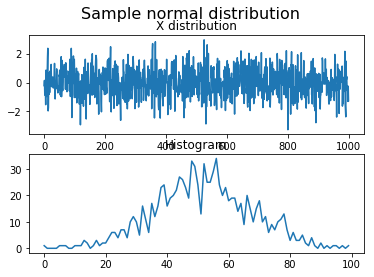

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=1)
axs = axs.flatten()
fig.suptitle('Sample normal distribution', fontsize=16)

x = torch.randn(1000)
axs[0].plot(x); axs[0].set_title(f'X distribution')
hist = torch.histc(x, bins=100)
axs[1].plot(hist); axs[1].set_title(f'Histogram')
print(x.std(), x.mean())

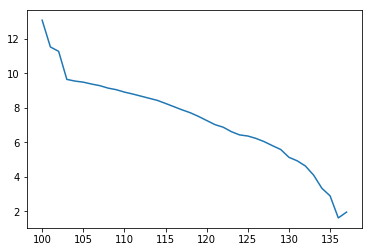

In [34]:
def viewFirstSlice(layer):
    x = layer[0]
    plt.plot(x.log())

viewFirstSlice(model.act_hist[0])

In [35]:
def getHistImg(act):
    dd = torch.cat(act).view(len(act), act[0].shape[0])
    # dd = torch.nn.Softmax(0)(dd) # Constraint 01
    #dd = dd * 255 # Scale for visualizaion
    dd = dd.log() # Scale for visualizaion
    dd = dd.t() # rotate
    dd = dd.flip(0) # Swap pos/neg Y
    return dd

def plotActHist(hists, cols=3):
    n=len(hists)
    cols = cols or 3
    rows = int(math.ceil(n/cols))
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20,10))
    fig.suptitle('Activations Y:log(histogram) X:batch', fontsize=16)
    axs = axs.flatten()

    for i,l in enumerate(hists):
        img=getHistImg(l)
        axs[i].imshow(getHistImg(l)); 
        axs[i].set_title(f'Layer {i}')
        imgH=img.shape[0]
#        plt.set_yticks([0,imgH/2,imgH],(str(-GLOBAL_HIST_AMPLITUDE),'0',str(GLOBAL_HIST_AMPLITUDE)))
        axs[i].set_yticks([])
        axs[i].set_ylabel(str(-GLOBAL_HIST_AMPLITUDE) + " : " + str(GLOBAL_HIST_AMPLITUDE))
        imgW=img.shape[1]
        imgH=img.shape[0]
        axs[i].plot([0,imgW],[imgH/2,imgH/2],'r') # X Axis
        
    #plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.subplots_adjust(hspace=0.4)
        
    #Remove unused axes:
    for i in range(n,rows*cols):
        fig.delaxes(axs[i])

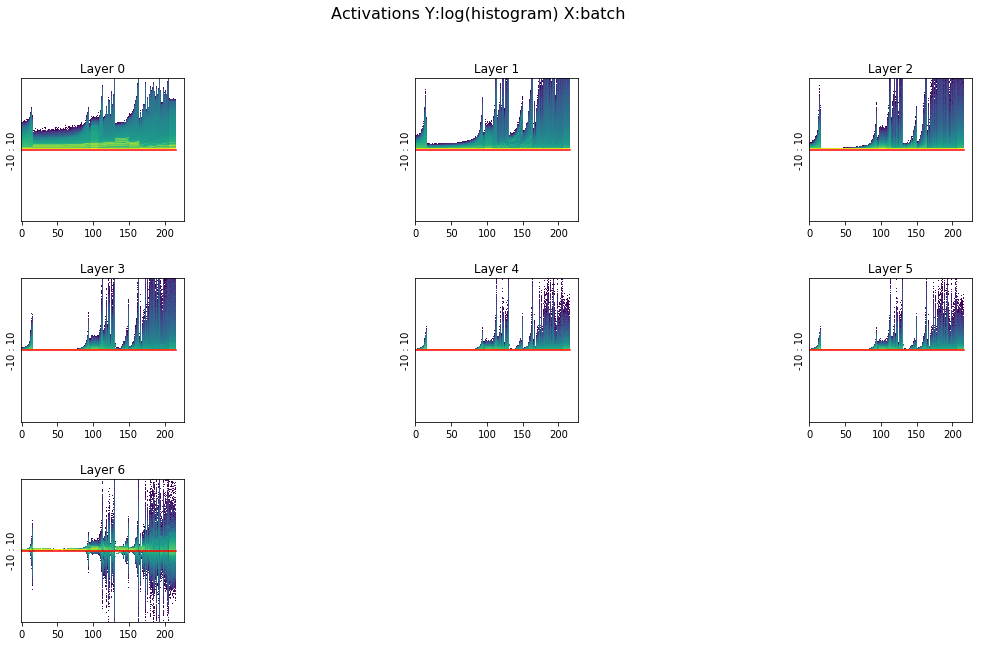

In [36]:
plotActHist(model.act_hist, cols=3)

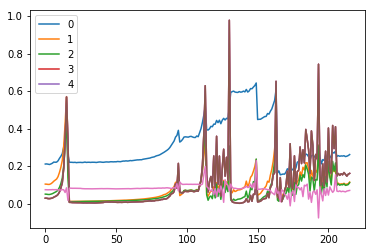

In [37]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

In [38]:
m0 = torch.Tensor(model.act_means[0])
s0 = torch.Tensor(model.act_stds[0])

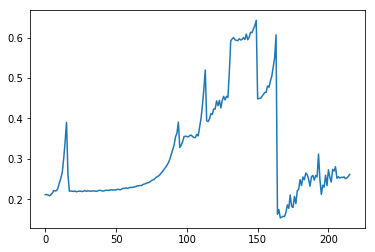

In [39]:
plt.plot(m0)

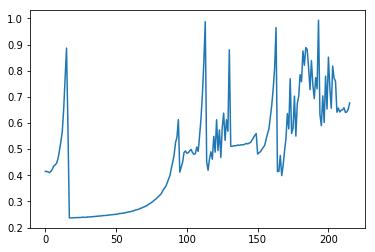

In [40]:
plt.plot(s0)

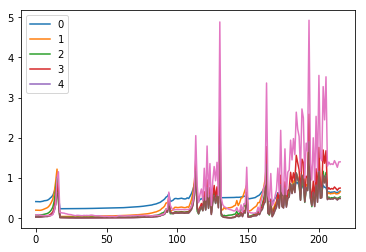

In [41]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

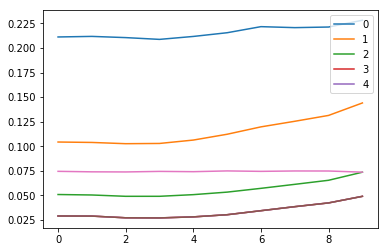

In [42]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

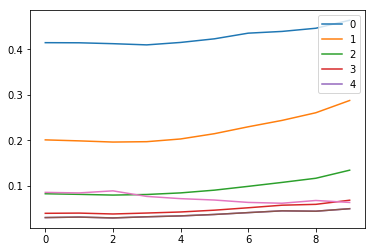

In [43]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

### Pytorch hooks

In [44]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [45]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [46]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.mean())
    act_stds [i].append(outp.std())

In [47]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [48]:
run.fit(1, learn)

train: [1.8575675, tensor(0.3473, device='cuda:0')]
valid: [0.741833203125, tensor(0.7435, device='cuda:0')]


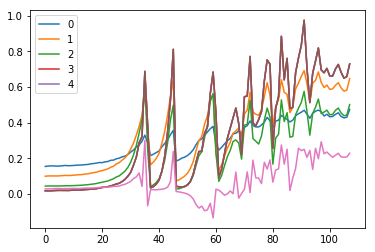

In [49]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

In [50]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): 
        self.means = []
        self.stds  = []
        self.act_hist  = []
        self.hook = m.register_forward_hook(partial(f, self))
        
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [51]:
def append_stats(hook, mod, inp, outp):
    hook.means.append(outp.mean())
    hook.stds .append(outp.std())
    hook.act_hist.append(mkHist(outp))

In [52]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [53]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [54]:
run.fit(1, learn)

train: [1.841629375, tensor(0.3464, device='cuda:0')]
valid: [0.9046638671875, tensor(0.6992, device='cuda:0')]


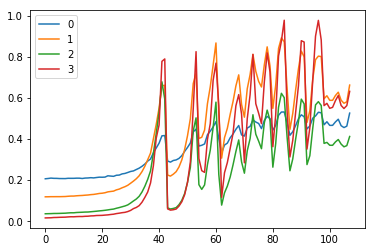

In [55]:
for h in hooks:
    plt.plot(h.means)
    h.remove()
plt.legend(range(4));

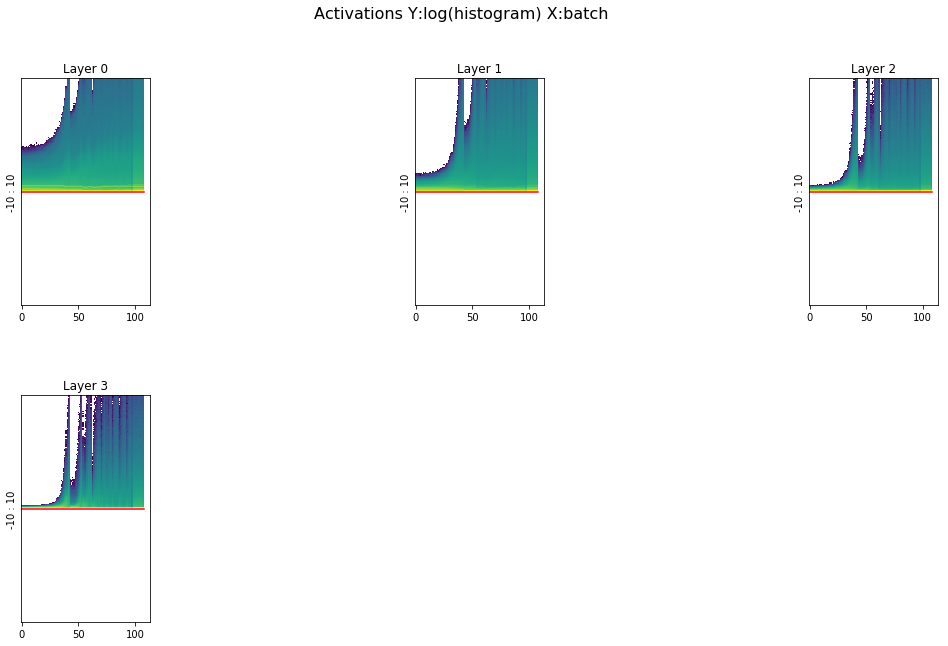

In [56]:
hists=[h.act_hist for h in hooks]
plotActHist(hists)

### A Hooks class

In [57]:
#export
from torch.nn import init

class Hooks():
    def __init__(self, ms, f): self.hooks = [Hook(m, f) for m in ms]
    def __getitem__(self,i): return self.hooks[i]
    def __len__(self): return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
        
    def remove(self):
        for h in self.hooks: h.remove()

In [58]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, lr=0.5)

In [59]:
x,y = next(iter(data.valid_dl))
x = mnist_resize(x).cuda()

In [60]:
x.mean(),x.std()

(tensor(-0.0127, device='cuda:0'), tensor(0.9849, device='cuda:0'))

In [61]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1143, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.2710, device='cuda:0', grad_fn=<StdBackward0>))

In [62]:
for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

In [63]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.3906, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.8054, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.255074375, tensor(0.5869, device='cuda:0')]
valid: [0.324934228515625, tensor(0.8933, device='cuda:0')]


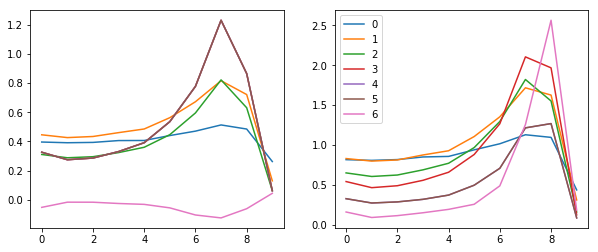

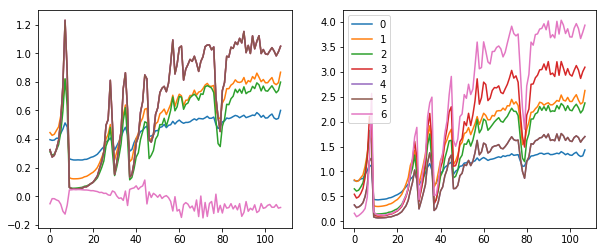

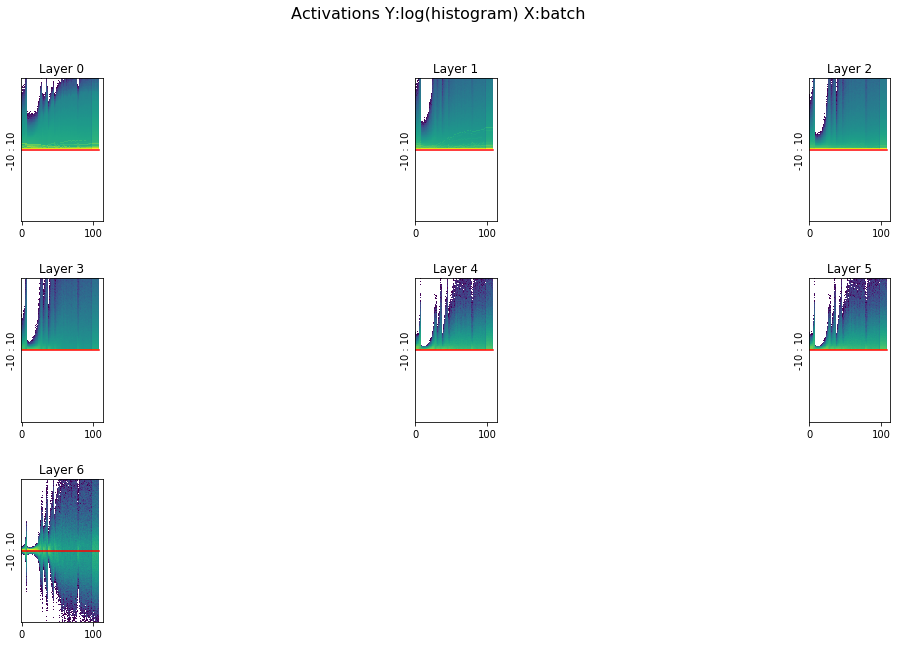

In [64]:
with Hooks(model, append_stats) as hooks:
    nl=len(hooks)
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
        h.remove()
    plt.legend(range(nl));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means)
        ax1.plot(h.stds)
    plt.legend(range(nl));
    
    plotActHist([h.act_hist for h in hooks])

## Generalized ReLU

In [65]:
#export
def get_cnn_layers(data, nfs, **kwargs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs, **kwargs): return nn.Sequential(*get_cnn_layers(data, nfs, **kwargs))

def conv2d(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [66]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))

for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight, a=0.1)

learn,run = get_runner(model, lr=0.1)

train: [1.47939609375, tensor(0.5572, device='cuda:0')]
valid: [0.58348984375, tensor(0.8545, device='cuda:0')]
train: [0.4658346484375, tensor(0.8704, device='cuda:0')]
valid: [0.33234609375, tensor(0.9082, device='cuda:0')]


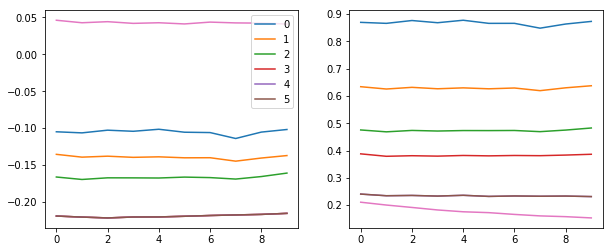

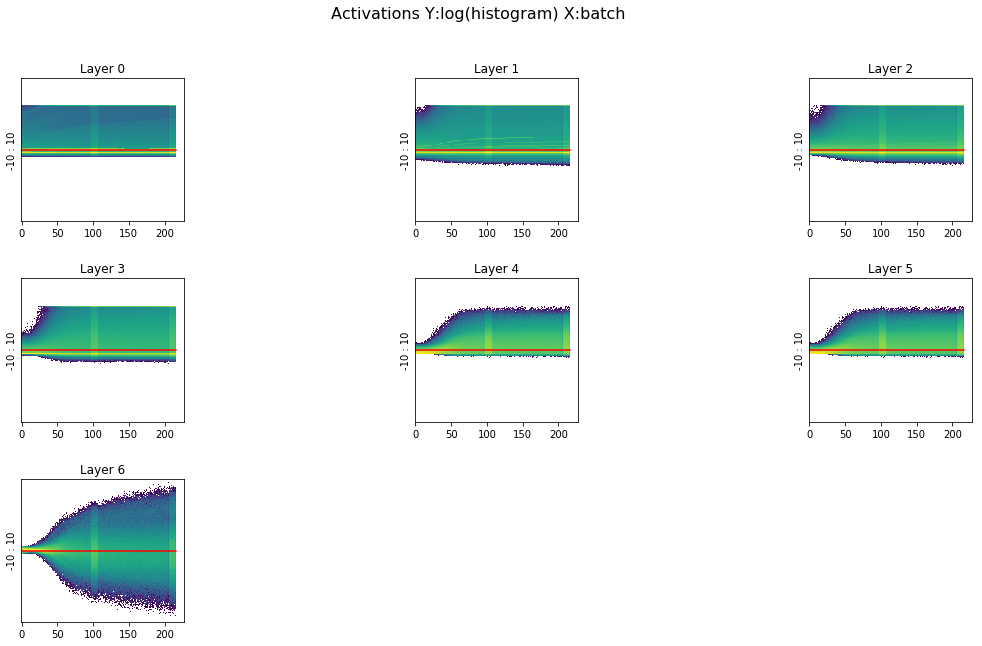

In [67]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));
    
    plotActHist([h.act_hist for h in hooks])

In [68]:
def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential):
            init.kaiming_normal_(l[0].weight, a=0.1)
            l[0].weight.data.mul_(1.1)

In [69]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
init_cnn(model)
learn,run = get_runner(model, lr=0.1)

train: [1.124404453125, tensor(0.6836, device='cuda:0')]
valid: [0.4614962890625, tensor(0.8833, device='cuda:0')]


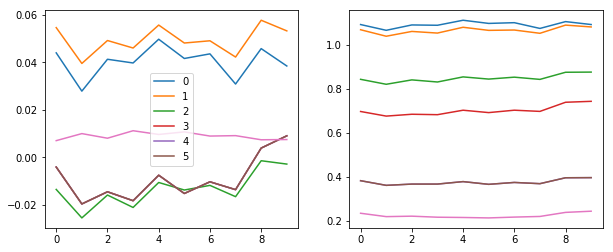

In [70]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));

In [71]:
def get_learn_run(nfs, lr, cbs=None):
    model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
    init_cnn(model)
    return get_runner(model, lr=lr, cbs=cbs)

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.2, 1.), sched_lin(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run([8, 16, 32, 64], 1., cbs=ParamScheduler('lr', sched))

In [ ]:
run.fit(8, learn)

## Export

In [ ]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb